In [ ]:
# !pip install emoji
# !pip install python-crfsuite
# !pip install Sastrawi

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import re
import emoji
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tag import CRFTagger
import re
import Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam


excelstopwords = pd.read_excel('stopwords.xlsx')
kamusalay= pd.read_csv("new_kamusalay.csv")

In [2]:
train = pd.read_csv('databagus.csv')
train

,label,tweet,num_label,filtering,length
0,fear,btw ya beneran ngeri sih olx sekarang ladang p...,1,by the way ya benar ngeri olx ladang tipu baru...,103
1,sadness,@adrianisonline onga eh. Oktober palang yata b...,3,onga eh oktober palang yata semangat na tayo d...,103
2,anger,Saya lelah dalam rasa sakit yang luar biasa da...,0,lelah sakit musuh,17
3,fear,Yang harus kita takutkan adalah ketika kita is...,1,takut istri anak tampak aurat hukum pasang fot...,60
4,joy,"Saya merasa sejuk, tenang dan terkumpul",2,sejuk tenang kumpul,19
...,...,...,...,...,...
24647,joy,Saya merasakan keterikatan seperti itu pada Ci...,2,rasa ikat cindy keluarga atticus manis,38
24648,love,saya benar-benar merasa panas kenyamanan makan...,2,panas nyaman makan minggu,25
24649,fear,"ada ga sih cewe yang tulus ke aku, takut patah...",1,tulus takut patah hati,22
24650,anger,"anjing kaget, typing lo minta di tabok apa gim...",0,anjing kaget etik tabok,23


In [3]:
train['num_label'] = train['label'].map({'anger':0, 'fear':1, 'joy':2, 'love':2, 'sadness':3})
train.head()

,label,tweet,num_label,filtering,length
0,fear,btw ya beneran ngeri sih olx sekarang ladang p...,1,by the way ya benar ngeri olx ladang tipu baru...,103
1,sadness,@adrianisonline onga eh. Oktober palang yata b...,3,onga eh oktober palang yata semangat na tayo d...,103
2,anger,Saya lelah dalam rasa sakit yang luar biasa da...,0,lelah sakit musuh,17
3,fear,Yang harus kita takutkan adalah ketika kita is...,1,takut istri anak tampak aurat hukum pasang fot...,60
4,joy,"Saya merasa sejuk, tenang dan terkumpul",2,sejuk tenang kumpul,19


In [4]:
train.groupby(by="num_label").count()

,label,tweet,filtering,length
num_label,,,,
0,5741,5741,5741,5741
1,5633,5633,5633,5633
2,7505,7505,7505,7505
3,5773,5773,5773,5773


In [5]:
def lowercase(review):
    return review.lower() #dari python langsung, bkn dari external library

# hapus URL
def remove_url(review):
    return re.sub(r'http\S+', '', review)

def remove_hashtags(review):
    # Pola regex untuk mendeteksi hashtag
    pattern = r'#\w+'
    return re.sub(pattern, '', review)

def remove_mentions(review):
    return re.sub(r'@\w+', '', review)

#KAMUS ALAY
def alay(review):
    alay_dic = kamusalay.to_dict()
    alay_dic = dict(zip(kamusalay.iloc[:,0], kamusalay.iloc[:,1]))
    words = review.split()
    for i in range(len(words)):
        word = words[i]
        if word in alay_dic.keys():
            words[i] = alay_dic[word]
    sentence = " ".join(words)
    return sentence

def remove_square_brackets(review):
    # Menghapus teks di dalam kurung siku beserta kurungnya
    return re.sub(r'\[.*?\]', '', review)

# hapus irrelevant char(angka, simbol, tanda baca)
def remove_irrelevant(review):
    return re.sub('[^a-zA-Z\s]', ' ', review)

# hapus spasi lebih dari 1
def remove_space(review):
    review= re.sub(r'\s+', ' ', review)
    review= review.replace('\n', ' ')
    review= review.replace('\\n', ' ')
    review= review.replace('\t', ' ')
    review= review.replace('\\t', ' ')
    review= review.replace('\\u', ' ')
    review= review.replace('\\', ' ')
    return review

# hapus emoji
def remove_emoji(review):
    emoji_pattern= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticon
                           u"\U0001F300-\U0001F5FF"  # simbol & dingbat
                           u"\U0001F680-\U0001F6FF"  # transportasi & simbol map
                           u"\U0001F700-\U0001F77F"  # simbol kuno
                           u"\U0001F780-\U0001F7FF"  # simbol kuno tambahan
                           u"\U0001F800-\U0001F8FF"  # simbol tanda batas
                           u"\U0001F900-\U0001F9FF"  # emoticon tambahan
                           u"\U0001FA00-\U0001FA6F"  # simbol musik
                           u"\U0001FA70-\U0001FAFF"  # simbol musik tambahan
                           u"\U00002702-\U000027B0"  # simbol karakter
                           u"\U000024C2-\U0001F251"  # simbol katakter tambahan
                           "]+", flags= re.UNICODE)
    return emoji_pattern.sub(r'', review)


#REMOVING REPEAT CHARACTER
def repeat_char(review):
    review= re.sub('([A-Za-z])\\1{2,}','\\1', review)
    return review


#Remove Stopword Indo
def remove_stopwords(sentence):
    stopwords_list = list(excelstopwords['stopwords'])
    words = sentence.split()
    no_words = [w for w in words if w not in stopwords_list]
    sentence = " ".join(no_words)
    return sentence


# Create stemmer
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()
# Stemming function
def stemmed(review):
    return stemmer.stem(review)



In [6]:
def df_prep(train):
    train['filtering']= train['tweet'].apply(lowercase)
    train['filtering']= train['filtering'].apply(remove_hashtags)
    train['filtering']= train['filtering'].apply(remove_url)
    train['filtering']= train['filtering'].apply(remove_mentions)
    train['filtering']= train['filtering'].apply(remove_square_brackets)
    train['filtering']= train['filtering'].apply(remove_irrelevant)
    train['filtering']= train['filtering'].apply(remove_space)
    train['filtering']= train['filtering'].apply(remove_emoji)
    train['filtering']= train['filtering'].apply(repeat_char)
    train['filtering']= train['filtering'].apply(alay)
    train["filtering"]= train["filtering"].apply(remove_stopwords)
    train['filtering']= train['filtering'].apply(stemmed)
    return train

In [ ]:
train = df_prep(train)
train = train.sample(frac=1).reset_index(drop=True)
train

In [7]:
train_split = 0.9
train_size = int(len(train['filtering'])*train_split)
traindata = train[0:train_size]
valdata = train[train_size:]

In [19]:
# Parameters for padding and OOV tokens
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
max_length = 250
#train['length'].max()
vocab_size = 16500 #coba dikecilkan biar ga overfit len(unique())
embedding_dim = 48

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')

# Generate the word index dictionary
tokenizer.fit_on_texts(traindata['filtering'])
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(traindata['filtering'])
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the validation sequences
validation_sequences = tokenizer.texts_to_sequences(valdata['filtering'])
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [20]:
print(len(word_index))

16512


In [21]:
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(16, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(4, activation='softmax')
])

learning_rate = 0.0001
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])


In [22]:
num_epochs = 60
BATCH_SIZE = 128
history = model.fit(training_padded, traindata['num_label'], batch_size = BATCH_SIZE, epochs=num_epochs,
                    validation_data=(validation_padded, valdata['num_label']), verbose=2)

Epoch 1/60
174/174 - 13s - loss: 1.3797 - accuracy: 0.3028 - val_loss: 1.3754 - val_accuracy: 0.3220
Epoch 2/60
174/174 - 13s - loss: 1.3662 - accuracy: 0.3372 - val_loss: 1.3594 - val_accuracy: 0.3544
Epoch 3/60
174/174 - 13s - loss: 1.3449 - accuracy: 0.3728 - val_loss: 1.3370 - val_accuracy: 0.3921
Epoch 4/60
174/174 - 13s - loss: 1.3147 - accuracy: 0.4131 - val_loss: 1.3051 - val_accuracy: 0.4197
Epoch 5/60
174/174 - 13s - loss: 1.2744 - accuracy: 0.4580 - val_loss: 1.2638 - val_accuracy: 0.4562
Epoch 6/60
174/174 - 13s - loss: 1.2263 - accuracy: 0.4911 - val_loss: 1.2167 - val_accuracy: 0.5109
Epoch 7/60
174/174 - 13s - loss: 1.1750 - accuracy: 0.5324 - val_loss: 1.1675 - val_accuracy: 0.5499
Epoch 8/60
174/174 - 13s - loss: 1.1201 - accuracy: 0.5720 - val_loss: 1.1201 - val_accuracy: 0.5888
Epoch 9/60
174/174 - 13s - loss: 1.0711 - accuracy: 0.6025 - val_loss: 1.0759 - val_accuracy: 0.6176
Epoch 10/60
174/174 - 12s - loss: 1.0242 - accuracy: 0.6411 - val_loss: 1.0344 - val_accura

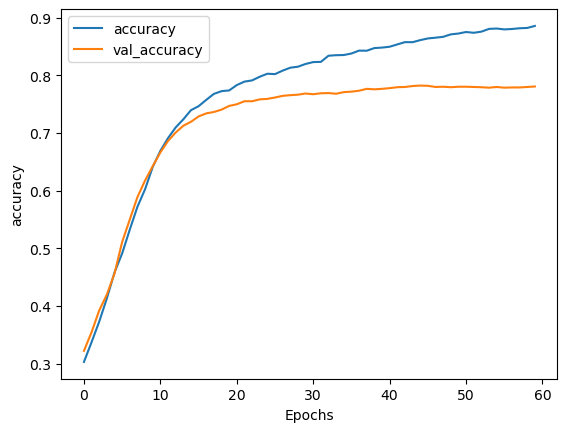

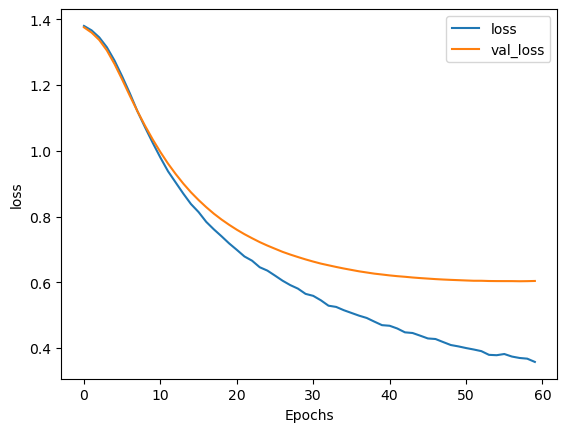

In [23]:
# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [24]:
validation_sequences = tokenizer.texts_to_sequences(valdata['filtering'])
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [25]:
result = model.predict(validation_padded)
# Get the index of the maximum probability for each row
predicted_labels = np.argmax(result, axis=1)
predicted_labels

array([0, 3, 3, ..., 1, 1, 0], dtype=int64)

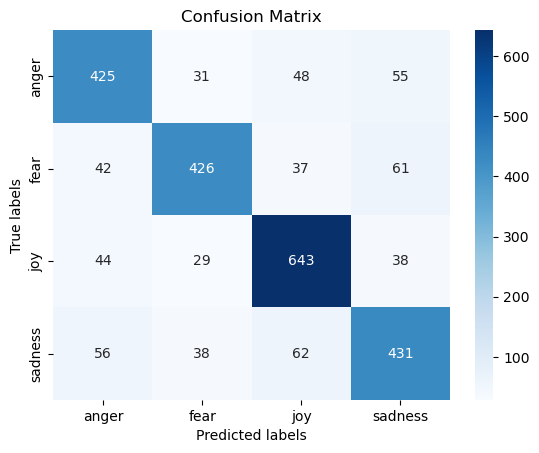

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Replace y_true and y_pred with your actual data
y_true = np.array(valdata['num_label']) # True labels
y_pred = predicted_labels  # Predicted labels

# Create the confusion matrix
label = ["anger", "fear", "joy", "sadness"]
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, cmap="Blues", annot = True, fmt='d', xticklabels=label, yticklabels=label)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision (macro, micro, and weighted)
precision_macro = precision_score(y_true, y_pred, average='macro')
precision_micro = precision_score(y_true, y_pred, average='micro')
precision_weighted = precision_score(y_true, y_pred, average='weighted')

# Calculate recall (macro, micro, and weighted)
recall_macro = recall_score(y_true, y_pred, average='macro')
recall_micro = recall_score(y_true, y_pred, average='micro')
recall_weighted = recall_score(y_true, y_pred, average='weighted')

# Calculate F1 score (macro, micro, and weighted)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

# Print all the metrics
print("Accuracy:", accuracy)
print("Precision (Macro):", precision_macro)
print("Precision (Micro):", precision_micro)
print("Precision (Weighted):", precision_weighted)
print("Recall (Macro):", recall_macro)
print("Recall (Micro):", recall_micro)
print("Recall (Weighted):", recall_weighted)
print("F1 Score (Macro):", f1_macro)
print("F1 Score (Micro):", f1_micro)
print("F1 Score (Weighted):", f1_weighted)


Accuracy: 0.7806163828061639
Precision (Macro): 0.7783030923785264
Precision (Micro): 0.7806163828061639
Precision (Weighted): 0.7807464736234869
Recall (Macro): 0.7749908639940895
Recall (Micro): 0.7806163828061639
Recall (Weighted): 0.7806163828061639
F1 Score (Macro): 0.7762330895415703
F1 Score (Micro): 0.7806163828061639
F1 Score (Weighted): 0.7802669941654814


### Data Test

In [28]:
test = pd.read_excel("data_test.xlsx")
test.head()

,tweet,label
0,"Aduh, pagi-pagi udah kena macet parah di jalan...",anger
1,"Tadi pagi waktu gue jalan ke sekolah, tiba-tib...",fear
2,Hari ini gue dapet kabar kalau temen deket gue...,sadness
3,Pagi tadi gue bangun dan liat cuaca cerah bang...,happy
4,Baru aja dapet kabar kalau proyek yang gue ker...,sadness


In [29]:
test['num_label'] = test['label'].map({'anger':0, 'fear':1, 'happy':2, 'love':2, 'sadness':3})
test.head()

,tweet,label,num_label
0,"Aduh, pagi-pagi udah kena macet parah di jalan...",anger,0
1,"Tadi pagi waktu gue jalan ke sekolah, tiba-tib...",fear,1
2,Hari ini gue dapet kabar kalau temen deket gue...,sadness,3
3,Pagi tadi gue bangun dan liat cuaca cerah bang...,happy,2
4,Baru aja dapet kabar kalau proyek yang gue ker...,sadness,3


In [30]:
test = df_prep(test)
test = test[test['filtering'] != ""].reset_index(drop=True)
test

,tweet,label,num_label,filtering
0,"Aduh, pagi-pagi udah kena macet parah di jalan...",anger,0,aduh pagi pagi kena macet parah jalan pas kant...
1,"Tadi pagi waktu gue jalan ke sekolah, tiba-tib...",fear,1,pagi jalan sekolah motor ngebut tabrak jantung...
2,Hari ini gue dapet kabar kalau temen deket gue...,sadness,3,teman pindah kota sedih sahabat pikir jarang k...
3,Pagi tadi gue bangun dan liat cuaca cerah bang...,happy,2,pagi bangun lihat cuaca cerah suasana hati lan...
4,Baru aja dapet kabar kalau proyek yang gue ker...,sadness,3,proyek kerjain bulan tolak klien sesal korban ...
...,...,...,...,...
130,8. Ketika seseorang menyebarkan gosip tidak be...,anger,0,sebar gosip diri amarahku langsung muncul kesa...
131,"9. Dalam antrian panjang, seseorang dengan sen...",anger,0,antre sengaja selak peduli orang amarahku lang...
132,9. Dalam perjalanan pulang setelah berhasil me...,happy,2,jalan pulang hasil selesai proyek bahagia penu...
133,"9. Dalam perjalanan pulang setelah perpisahan,...",sadness,3,jalan pulang pisah hati berat sedih limut piki...


In [31]:
test_sequences = tokenizer.texts_to_sequences(test['filtering'])
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded

array([[451,  54,  54, ...,   0,   0,   0],
       [ 54,  17,  62, ...,   0,   0,   0],
       [ 13, 348, 272, ...,   0,   0,   0],
       ...,
       [ 17,  99,  71, ...,   0,   0,   0],
       [ 17,  99, 433, ...,   0,   0,   0],
       [ 93, 164, 875, ...,   0,   0,   0]])

In [35]:
result_test = model.predict(test_padded)
result_test
# Get the index of the maximum probability for each row
predicted_labels_test = np.argmax(result_test, axis=1)
predicted_labels_test

array([0, 1, 3, 2, 3, 0, 1, 2, 0, 1, 0, 1, 3, 2, 3, 0, 1, 3, 2, 0, 1, 3,
       2, 0, 1, 3, 2, 3, 1, 0, 2, 0, 1, 2, 0, 3, 1, 3, 0, 0, 1, 2, 1, 0,
       1, 3, 2, 0, 1, 3, 2, 1, 1, 0, 2, 1, 2, 3, 0, 0, 1, 2, 3, 0, 1, 2,
       3, 2, 3, 1, 0, 1, 2, 3, 0, 0, 2, 1, 3, 3, 1, 2, 0, 1, 3, 0, 2, 2,
       1, 3, 0, 0, 3, 2, 1, 1, 0, 2, 3, 2, 3, 1, 0, 0, 1, 2, 3, 0, 3, 2,
       1, 1, 0, 3, 2, 2, 0, 3, 1, 3, 3, 0, 1, 2, 1, 3, 0, 1, 3, 2, 0, 0,
       2, 3, 1], dtype=int64)

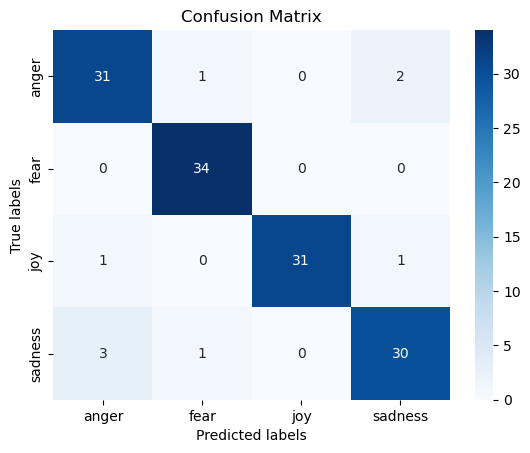

In [37]:
# Replace y_true and y_pred with your actual data
y_true = np.array(test['num_label']) # True labels
y_pred = predicted_labels_test  # Predicted labels

# Create the confusion matrix
label = ["anger", "fear", "joy", "sadness"]
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, cmap="Blues", annot = True, fmt='d', xticklabels=label, yticklabels=label)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision (macro, micro, and weighted)
precision_macro = precision_score(y_true, y_pred, average='macro')
precision_micro = precision_score(y_true, y_pred, average='micro')
precision_weighted = precision_score(y_true, y_pred, average='weighted')

# Calculate recall (macro, micro, and weighted)
recall_macro = recall_score(y_true, y_pred, average='macro')
recall_micro = recall_score(y_true, y_pred, average='micro')
recall_weighted = recall_score(y_true, y_pred, average='weighted')

# Calculate F1 score (macro, micro, and weighted)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

# Print all the metrics
print("Accuracy:", accuracy)
print("Precision (Macro):", precision_macro)
print("Precision (Micro):", precision_micro)
print("Precision (Weighted):", precision_weighted)
print("Recall (Macro):", recall_macro)
print("Recall (Micro):", recall_micro)
print("Recall (Weighted):", recall_weighted)
print("F1 Score (Macro):", f1_macro)
print("F1 Score (Micro):", f1_micro)
print("F1 Score (Weighted):", f1_weighted)


Accuracy: 0.9333333333333333
Precision (Macro): 0.9348124098124098
Precision (Micro): 0.9333333333333333
Precision (Weighted): 0.9343295387739831
Recall (Macro): 0.9333778966131907
Recall (Micro): 0.9333333333333333
Recall (Weighted): 0.9333333333333333
F1 Score (Macro): 0.9335629210314885
F1 Score (Micro): 0.9333333333333333
F1 Score (Weighted): 0.9333022760020921


#### Test

In [39]:
def prediction(test):
    label = ["anger", "fear", "joy", "sadness"]
    result = model.predict(test)
    index = np.argmax(result)
    hasil = label[index]
    return result[0], hasil

def prep_test(reviews):
    review = lowercase(reviews)
    review = remove_url(review)
    review = remove_mentions(review)
    review = remove_square_brackets(review)
    review = remove_irrelevant(review)
    review = remove_space(review)
    review = remove_emoji(review)
    review = repeat_char(review)
    review = alay(review)
    review = remove_stopwords(review)
    review = stemmed(review)
    text = [review]
    inference_sequences = tokenizer.texts_to_sequences(text)
    inference_padded = pad_sequences(inference_sequences, padding=padding_type, maxlen=max_length)
    
    results = prediction(inference_padded)
    print(reviews)
    print("")
    print(f"Probability Anger: {results[0][0]:.2f}")
    print(f"Probability Fear: {results[0][1]:.2f}")
    print(f"Probability Sadness: {results[0][3]:.2f}")
    print(f"Probability Joy: {results[0][2]:.2f}")
    print("")
    print(f"Mood Anda saat ini adalah: {results[1]}")
    return results

In [40]:
text = "Aaaaarrgghhh ga kuat gue tahan lagi cokk. Laper sih laper, tapi perasaan kayak ada yang nyangkut di tenggorokan. Scroll medsos isinya pamer bahagia mulu. Bikin iri aja deh. Pengin cerita ke temen tapi takut dibilang drama queen.  Mereka lagi pada sibuk sama kesenangannya sendiri.Kadang mikir, apa gue salah ya? Kok hidup gue gini-gini aja.  Dulu mimpi setinggi langit, sekarang nyampe langit-langitnya tetangga sebelah aja engga.  Nilai jelek, dimarahin orang tua.  Belum lagi gebetan kayanya ngga ngeliatin gue sama sekali.  Duh, kayaknya gue butuh miracle deh biar bisa keluar dari zona galau ini.  Tapi percintaan kayak di drama korea itu cuma khayalan doang kali ya. Mending gue tidur aja deh.  Siapa tau besok bangun suasana hati udah lebih baikan.  Tapi ntar kalo mimpi buruk gimana?  Haduh, serba salah emang.  Yaudahlah, pasrah aja deh sama keadaan.  Mungkin ini emang lagi diuji kesabarannya.  Siapa tau nanti ada hikmahnya  nangis sambil elap ingus"
hasil = prep_test(text)

Aaaaarrgghhh ga kuat gue tahan lagi cokk. Laper sih laper, tapi perasaan kayak ada yang nyangkut di tenggorokan. Scroll medsos isinya pamer bahagia mulu. Bikin iri aja deh. Pengin cerita ke temen tapi takut dibilang drama queen.  Mereka lagi pada sibuk sama kesenangannya sendiri.Kadang mikir, apa gue salah ya? Kok hidup gue gini-gini aja.  Dulu mimpi setinggi langit, sekarang nyampe langit-langitnya tetangga sebelah aja engga.  Nilai jelek, dimarahin orang tua.  Belum lagi gebetan kayanya ngga ngeliatin gue sama sekali.  Duh, kayaknya gue butuh miracle deh biar bisa keluar dari zona galau ini.  Tapi percintaan kayak di drama korea itu cuma khayalan doang kali ya. Mending gue tidur aja deh.  Siapa tau besok bangun suasana hati udah lebih baikan.  Tapi ntar kalo mimpi buruk gimana?  Haduh, serba salah emang.  Yaudahlah, pasrah aja deh sama keadaan.  Mungkin ini emang lagi diuji kesabarannya.  Siapa tau nanti ada hikmahnya  nangis sambil elap ingus

Probability Anger: 0.56
Probability Fea

In [41]:
text = "Aduh, ga nyangka deh ternyata ada yang sayang sama gue. Rasanya kayak mimpi! Selama ini gue selalu ngerasa sendirian, ga ada yang peduli. Tapi sekarang, ada dia yang selalu ada buat gue. Dia selalu ngehubungin gue setiap hari, nanyain gimana kabar gue, ngajak gue jalan-jalan, dan selalu ngasih perhatian yang bikin gue bahagia. Gue ga tau harus gimana lagi. Gue ga mau ngecewain dia, tapi gue juga ga mau ngasih harapan yang berlebihan. Gue bingung mau ngambil sikap kayak apa. Yang jelas, gue seneng banget bisa ngerasain dicintai lagi. Gue ga mau ngelepasin dia. Gue pengen selalu bareng dia dan bahagia sama dia. Tapi gue takut kalo gue terlalu ngedekatin dia, dia bakalan ngerasa terbebani. Gue ga mau dia ngerasa terpaksa buat sayang sama gue. Gue harap dia beneran sayang sama gue, bukan cuma karena kasihan atau ngerasa kesepian. Gue pengen cinta yang tulus dan abadi. Gue tau gue ga sempurna. Gue banyak kekurangan. Tapi gue janji bakal berusaha jadi yang terbaik buat dia. Gue bakal ngasih dia cinta yang tulus dan kasih sayang yang tiada tara. Gue harap dia mau ngertiin gue dan ngasih gue kesempatan buat ngbuktiin cinta gue. Gue ga mau ngelepasin dia. Gue pengen selalu bareng dia dan bahagia sama dia."
hasil = prep_test(text)

Aduh, ga nyangka deh ternyata ada yang sayang sama gue. Rasanya kayak mimpi! Selama ini gue selalu ngerasa sendirian, ga ada yang peduli. Tapi sekarang, ada dia yang selalu ada buat gue. Dia selalu ngehubungin gue setiap hari, nanyain gimana kabar gue, ngajak gue jalan-jalan, dan selalu ngasih perhatian yang bikin gue bahagia. Gue ga tau harus gimana lagi. Gue ga mau ngecewain dia, tapi gue juga ga mau ngasih harapan yang berlebihan. Gue bingung mau ngambil sikap kayak apa. Yang jelas, gue seneng banget bisa ngerasain dicintai lagi. Gue ga mau ngelepasin dia. Gue pengen selalu bareng dia dan bahagia sama dia. Tapi gue takut kalo gue terlalu ngedekatin dia, dia bakalan ngerasa terbebani. Gue ga mau dia ngerasa terpaksa buat sayang sama gue. Gue harap dia beneran sayang sama gue, bukan cuma karena kasihan atau ngerasa kesepian. Gue pengen cinta yang tulus dan abadi. Gue tau gue ga sempurna. Gue banyak kekurangan. Tapi gue janji bakal berusaha jadi yang terbaik buat dia. Gue bakal ngasih 

In [42]:
text = "Woyy bestie, gw mau curhat nih. Gw lagi apes bgt guys. Semester ini gw harus ngulang mata kuliah Kalkulus Dasar. Sumpah deh gw gak nyangka bakal ngulang matkul ini. Gw udah belajar mati-matian loh, begadang sampe mata panda, ngerjain semua tugas, tapi tetep aja nilai gw gak sampe KKM. Kesel bgt sih sebenernya. Gw udah ngerasa berusaha maksimal, tapi hasilnya gak sesuai ekspektasi. Malah bikin mental gw down bgt. ☹️☹️☹️ Apalagi ngeliat temen-temen yang lain udah pada lanjut ke materi selanjutnya, sementara gw masih harus terjebak di materi yang sama. Kayak anak bawang yang gak naik kelas aja rasanya. Belum lagi nanti gw harus ngulang bareng anak-anak angkatan bawah. Malu bgt sih rasanya. Gw jadi kayak gak pinter dan gak mampu gitu. Tapi mau gimana lagi, ini udah kenyataan yang harus gw hadapi. Gw gak boleh nyerah gitu aja. Gw harus semangat lagi dan belajar lebih giat biar di semester depan gak ngulang lagi. Bestie, doain gw yaaa biar gw bisa sukses ngulang Kalkulus Dasar dan gak ngerasa down lagi. Semangat bestie!"
hasil = prep_test(text)

Woyy bestie, gw mau curhat nih. Gw lagi apes bgt guys. Semester ini gw harus ngulang mata kuliah Kalkulus Dasar. Sumpah deh gw gak nyangka bakal ngulang matkul ini. Gw udah belajar mati-matian loh, begadang sampe mata panda, ngerjain semua tugas, tapi tetep aja nilai gw gak sampe KKM. Kesel bgt sih sebenernya. Gw udah ngerasa berusaha maksimal, tapi hasilnya gak sesuai ekspektasi. Malah bikin mental gw down bgt. ☹️☹️☹️ Apalagi ngeliat temen-temen yang lain udah pada lanjut ke materi selanjutnya, sementara gw masih harus terjebak di materi yang sama. Kayak anak bawang yang gak naik kelas aja rasanya. Belum lagi nanti gw harus ngulang bareng anak-anak angkatan bawah. Malu bgt sih rasanya. Gw jadi kayak gak pinter dan gak mampu gitu. Tapi mau gimana lagi, ini udah kenyataan yang harus gw hadapi. Gw gak boleh nyerah gitu aja. Gw harus semangat lagi dan belajar lebih giat biar di semester depan gak ngulang lagi. Bestie, doain gw yaaa biar gw bisa sukses ngulang Kalkulus Dasar dan gak ngeras

In [ ]:
train.to_csv("dataenakkk.csv", index=False)

In [43]:
from tensorflow.keras.preprocessing.text import Tokenizer
import json

In [44]:
# Get the word index from the tokenizer
word_index = tokenizer.word_index

# Save word index to a JSON file
with open('word_index12_fix.json', 'w') as f:
    json.dump(word_index, f)

In [ ]:
train.to_csv("data_fix_fixed.csv", index=False)

In [50]:
model.save('my_keras_model_fix.h5') #nama file

In [51]:
!tensorflowjs_converter --input_format keras my_keras_model_fix.h5 tfjs_model

In [52]:
import os
os.listdir('tfjs_model')
#nama file

['group1-shard1of1.bin', 'model.json']